# Total field vs primary-secondary field

We usually use `emg3d` for total field calculations. However, we could also use it in a primary-secondary field formulation, where we could calculate the primary field with a (semi-)analytical solution.

In this notebook we use `emg3d` to calculate

- Total field
- Primary field
- Secondary field

and compare the total field to the primary+secondary field.

One could replace the primary-field calculation by a 1D modeller such as `empymod`. You could play around with the required calculation-domain: Using a primary-secondary formulation should make it possible to restrict the required calculation domain for the scatterer a lot, therefore speeding up the calculation. However, we do not dive into that in this notebook.


## Background

Total field is given by

$$
    s \mu \sigma \mathbf{\hat{E}} + \nabla \times
    \nabla \times \mathbf{\hat{E}} =
    -s\mu\mathbf{\hat{J}}_s .
$$

We can split the total field up into a primary field $\mathbf{\hat{E}}^p$ and a secondary field $\mathbf{\hat{E}}^s$,

$$
 \mathbf{\hat{E}} =  \mathbf{\hat{E}}^p + \mathbf{\hat{E}}^s,
$$

where we also have to split our conductivity model into

$$
\sigma = \sigma^p + \Delta\sigma.
$$

The primary field could just be the direct field, or the direct field plus the air layer, or an entire 1D background, something that can be calculated (semi-)analytically. The secondary field is everything that is not included in the primary field.

The primary field is then given by

$$
    s \mu \sigma^p \mathbf{\hat{E}}^p + \nabla \times
    \nabla \times \mathbf{\hat{E}}^p =
    -s\mu\mathbf{\hat{J}}_s ,
$$

and the secondary field can be calculated using the primary field as source,

$$
    s \mu \sigma \mathbf{\hat{E}}^s + \nabla \times
    \nabla \times \mathbf{\hat{E}}^s =
    -s\mu\Delta\sigma\mathbf{\hat{E}}^p .
$$

In [1]:
import emg3d
import discretize
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

In [2]:
# Style adjustments
%matplotlib notebook
plt.style.use('ggplot')

## Survey

In [3]:
src = [0, 0, -950, 0, 0]    # x-directed source at the origin, 50 m above seafloor
off = np.arange(5, 81)*100  # Offsets
rec = [off, off*0, -1000]   # In-line receivers on the seafloor
res = [1e10, 0.3, 1]        # Resistivities (Hz): [air, seawater, background]
freq = 1.0                  # Frequency (Ohm.m)

## Mesh

We create quite a coarse grid (100 m minimum cell width), to have reasonable fast calculation times.

Also note that the mesh here includes a large boundary because of the air layer. If you use a semi-analytical solution for the 1D background you could restrict that domain a lot.

In [4]:
meshinp = {'freq': freq, 'min_width': 100, 'verb': 0}
xx, x0 = emg3d.utils.get_hx_h0(
    res=[res[1], 100.], fixed=src[0], domain=[-100, 8100], **meshinp)
yy, y0 = emg3d.utils.get_hx_h0(
    res=[res[1], 100.], fixed=src[1], domain=[-500, 500], **meshinp)
zz, z0 = emg3d.utils.get_hx_h0(
    res=[res[1], res[2], 100.], domain=[-2500, 0], fixed=[-1000, 0, -2000], **meshinp)

grid = discretize.TensorMesh([xx, yy, zz], x0=np.array([x0, y0, z0]))
grid

TensorMesh: 245,760 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    128    -33,701.05     41,701.05    100.00  5,464.87    1.19
   y     40    -31,889.10     31,889.10    100.00  8,064.40    1.34
   z     48     -6,202.87     31,389.10    100.00  8,064.40    1.34

## Create model

<IPython.core.display.Javascript object>


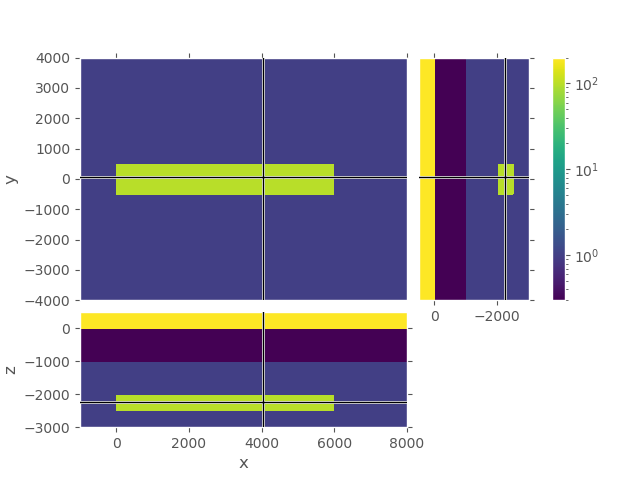

In [5]:
# Layered_background
res_x = np.ones(grid.nC)*res[0]            # Air resistivity
res_x[grid.gridCC[:, 2] < 0] = res[1]      # Water resistivity
res_x[grid.gridCC[:, 2] < -1000] = res[2]  # Background resistivity

# Background model
model_pf = emg3d.utils.Model(grid, res_x.copy())

# Include the target
xx = (grid.gridCC[:, 0] >= 0) & (grid.gridCC[:, 0] <= 6000)
yy = abs(grid.gridCC[:, 1]) <= 500
zz = (grid.gridCC[:, 2] > -2500)*(grid.gridCC[:, 2] < -2000)

res_x[xx*yy*zz] = 100.  # Target resistivity

# Create target model
model = emg3d.utils.Model(grid, res_x)

# Plot a slice
grid.plot_3d_slicer(model.res_x, zslice=-2250, clim=[0.3, 200],
                    xlim=(-1000, 8000), ylim=(-4000, 4000), zlim=(-3000, 500),
                    pcolorOpts={'norm': LogNorm()}
                   )

## Calculate total field with `emg3d`

In [6]:
modparams = {'verb': -1, 'sslsolver': True, 'semicoarsening': True, 'linerelaxation': True}

In [7]:
sfield_tf = emg3d.utils.get_source_field(grid, src, freq, strength=0)
em3_tf = emg3d.solver.solver(grid, model, sfield_tf, **modparams)

:: emg3d :: 9.0e-07; 1(4); 0:00:17; CONVERGED


## Calculate primary field (1D background) with `emg3d`

Here we use `emg3d` to calculate the primary field. This could be replaced by a (semi-)analytical solution.

In [8]:
sfield_pf = emg3d.utils.get_source_field(grid, src, freq, strength=0)
em3_pf = emg3d.solver.solver(grid, model_pf, sfield_pf, **modparams)

:: emg3d :: 8.5e-07; 1(4); 0:00:17; CONVERGED


## Calculate secondary field (scatterer) with `emg3d`

### Define the secondary source

In [9]:
# Get the difference of conductivity as volume-average values
dsigma = grid.vol.reshape(grid.vnC, order='F')*(1/model.res_x-1/model_pf.res_x)

# Here we use the primary field calculated with emg3d. This could be done
# with a 1D modeller such as empymod instead.
fx = em3_pf.fx.copy()
fy = em3_pf.fy.copy()
fz = em3_pf.fz.copy()

# Average delta sigma to the corresponding edges
fx[:, 1:-1, 1:-1] *= 0.25*(dsigma[:, :-1, :-1] + dsigma[:, 1:, :-1] + dsigma[:, :-1, 1:] + dsigma[:, 1:, 1:])
fy[1:-1, :, 1:-1] *= 0.25*(dsigma[:-1, :, :-1] + dsigma[1:, :, :-1] + dsigma[:-1, :, 1:] + dsigma[1:, :, 1:])
fz[1:-1, 1:-1, :] *= 0.25*(dsigma[:-1, :-1, :] + dsigma[1:, :-1, :] + dsigma[:-1, 1:, :] + dsigma[1:, 1:, :])

# Create field instance iwu dsigma E
sfield_sf = sfield_pf.smu0*emg3d.utils.Field(fx, fy, fz, freq=freq)
sfield_sf.ensure_pec

### Plot the secondary source

Our secondary source is the entire target, the scatterer. Here we look at the $E_x$ secondary source field. But note that the secondary source has all three components $E_x$, $E_y$, and $E_z$, even though our primary source was purely $x$-directed. (Change `fx` to `fy` or `fz` in the command below, and simultaneously `Ex` to `Ey` or `Ez`, to show the other source fields.)

<IPython.core.display.Javascript object>


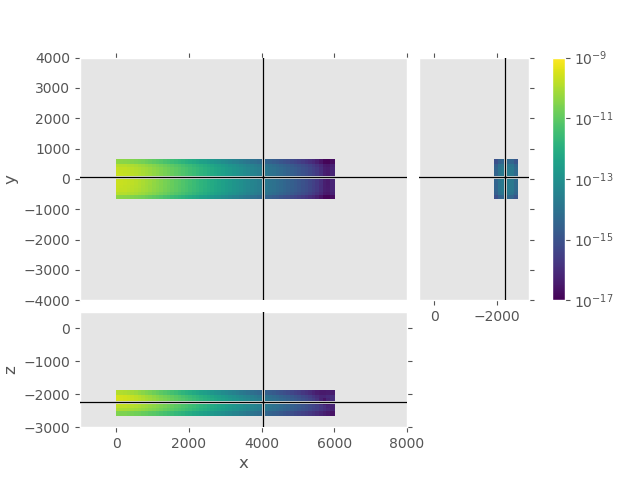

In [10]:
grid.plot_3d_slicer(sfield_sf.fx.ravel('F'), view='abs', vType='Ex',
                    zslice=-2250, clim=[1e-17, 1e-9],
                    xlim=(-1000, 8000), ylim=(-4000, 4000), zlim=(-3000, 500),
                    pcolorOpts={'norm': LogNorm()}
                   )

### Calculate the secondary source

In [11]:
em3_sf = emg3d.solver.solver(grid, model, sfield_sf, **modparams)

:: emg3d :: 9.9e-07; 1(6); 0:00:28; CONVERGED


## Plot result

In [12]:
# E = E^p + E^s
em3_ps = em3_pf + em3_sf

# Get the responses at receiver locations
em3_pf_rec = emg3d.utils.get_receiver(grid, em3_pf.fx, (rec[0], rec[1], rec[2]))
em3_tf_rec = emg3d.utils.get_receiver(grid, em3_tf.fx, (rec[0], rec[1], rec[2]))
em3_sf_rec = emg3d.utils.get_receiver(grid, em3_sf.fx, (rec[0], rec[1], rec[2]))
em3_ps_rec = emg3d.utils.get_receiver(grid, em3_ps.fx, (rec[0], rec[1], rec[2]))

<IPython.core.display.Javascript object>


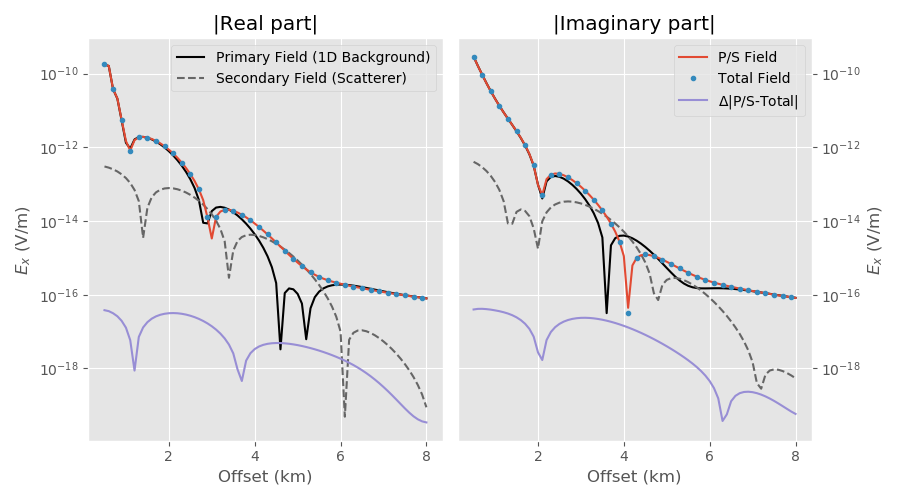

In [13]:
plt.figure(figsize=(9, 5))

ax1 = plt.subplot(121)
plt.title('|Real part|')
plt.plot(off/1e3, abs(em3_pf_rec.real), 'k', label='Primary Field (1D Background)')
plt.plot(off/1e3, abs(em3_sf_rec.real), '.4', ls='--', label='Secondary Field (Scatterer)')
plt.plot(off/1e3, abs(em3_ps_rec.real))
plt.plot(off[::2]/1e3, abs(em3_tf_rec[::2].real), '.')
plt.plot(off/1e3, abs(em3_ps_rec.real-em3_tf_rec.real))
plt.xlabel('Offset (km)')
plt.ylabel('$E_x$ (V/m)')
plt.yscale('log')
plt.legend()

ax2 = plt.subplot(122, sharey=ax1)
plt.title('|Imaginary part|')
plt.plot(off/1e3, abs(em3_pf_rec.imag), 'k')
plt.plot(off/1e3, abs(em3_sf_rec.imag), '.4', ls='--')
plt.plot(off/1e3, abs(em3_ps_rec.imag), label='P/S Field')
plt.plot(off[::2]/1e3, abs(em3_tf_rec[::2].imag), '.', label='Total Field')
plt.plot(off/1e3, abs(em3_ps_rec.imag-em3_tf_rec.imag), label='$\Delta$|P/S-Total|')
plt.xlabel('Offset (km)')
plt.ylabel('$E_x$ (V/m)')
plt.yscale('log')
ax2.yaxis.tick_right()
ax2.yaxis.set_label_position("right")
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
emg3d.Report([discretize, ])

--------------------------------------------------------------------------------
  Date: Fri Jan 03 08:17:46 2020 CET

             Linux : OS
                 4 : CPU(s)
            x86_64 : Machine
             64bit : Architecture
            7.7 GB : RAM
           Jupyter : Environment

  Python 3.7.5 (default, Oct 25 2019, 15:51:11)  [GCC 7.3.0]

            0.4.10 : discretize
            1.17.4 : numpy
             1.3.2 : scipy
            0.46.0 : numba
             0.9.2 : emg3d
            7.10.2 : IPython
             3.1.1 : matplotlib

  Intel(R) Math Kernel Library Version 2019.0.5 Product Build 20190808 for
  Intel(R) 64 architecture applications
--------------------------------------------------------------------------------